In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

## Auxiliary Functions

In [6]:
def showImage(image, name):
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [7]:
path = "results"

def saveImage(image, name):
    cv2.imwrite(os.path.join(path , name),image)
    cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [4]:
def convImgToBinary(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_binary

In [5]:
def RemoveRedMask(img):
    
    lower_red = np.array([0, 0, 128])
    upper_red = np.array([0, 0, 255])
 
    mask = cv2.inRange(img, lower_red, upper_red)
    
    maskNoRed= np.copy(img)
    maskNoRed[mask != 0] = [0, 0, 0]
    
    binaryMaskNoRed = convImgToBinary(maskNoRed)
    binaryMaskNoRed = cv2.cvtColor(binaryMaskNoRed, cv2.COLOR_GRAY2RGB)
    
    return binaryMaskNoRed

In [6]:
def CompareResult(BlendingResult, S2, metric):
    
    if metric == 1:
        # Signal to noise ratio, units: decibals
        ErrorValue = cv2.PSNR(S2,BlendingResult)
        print("PSNR: ", ErrorValue,"dB")
        pass
    elif metric == 2:
        # mean structural similarity index over the image, unit: index between 0 & 1
        ErrorValue = ssim(S2, BlendingResult, multichannel=True)
        print("SSIM: ", ErrorValue)
        pass
    elif metric == 3:
        # mean-squared error between two images
        ErrorValue = mse(S2, BlendingResult)
        print("MSE: ", ErrorValue)
        pass
    else:
        ErrorValue = "No Metric Specified"
        pass
    
    return ErrorValue

## Functions

In [7]:
def inpaintTelea(img, mask, inpaintRadius = 25):
    inpaintImg = cv2.inpaint(img, mask, inpaintRadius, cv2.INPAINT_TELEA)
    return inpaintImg

In [8]:
def inpaintNS(img, mask, inpaintRadius = 25):
    inpaintImg = cv2.inpaint(img, mask, inpaintRadius, cv2.INPAINT_NS)
    return inpaintImg

In [4]:
def getDiffBetweenImgs(img1, img2):
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Work out the SSIM between two images
    (score, diff) = ssim(img1_gray, img2_gray, full=True)
    print("Image similarity", score)

    # The diff image contains the actual image differences between the two images and is represented as a floating point data type in the range [0,1] 
    # so we must convert the array to 8-bit unsigned integers in the range [0,255] before we can use it with OpenCV
    diff = (diff * 255).astype("uint8")

    # Threshold the difference image, followed by finding contours to obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    mask = np.zeros(img1.shape, dtype='uint8')
    filled_img2 = img2.copy()

    for c in contours:
        area = cv2.contourArea(c)
        if area > 40:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(img1, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.rectangle(img2, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.drawContours(mask, [c], 0, (0,255,0), -1)
            cv2.drawContours(filled_img2, [c], 0, (0,255,0), -1)

    showImage(img1, "Image 1")
    showImage(img2, "Image 2")
    showImage(diff, "Differences")
    showImage(mask, "Mask")
    showImage(filled_img2, "Filled Image 2")

## Runner

#### Simple runner

## Task A - Simple Background

In [10]:
inpRadius = 30

cols = ["S1","S2","Mask","Telea","NS"]
rows = ["LP Books               ", "Footwear               ", "Statues               "]

images = []

books = []
books.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/1_colour.jpeg", 1))
books.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/2_colour.jpeg", 1))
books.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/masks/lpbooks_no_3_colour_mask_1_mask.png", 1))
images.append(books)

footwear = []
footwear.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/footwear_no/2_colour.jpeg", 1))
footwear.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/footwear_no/3_colour.jpeg", 1))
footwear.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/footwear_no/masks/footware_no_3_colour_mask_3_mask.png", 1))
images.append(footwear)

statues = []
statues.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/statues_oc/1_colour.jpeg", 1))
statues.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/statues_oc/2_colour.jpeg", 1))
statues.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/statues_oc/masks/statues_oc_3_colour_mask_4_mask.png", 1))
images.append(statues)

for i,imgs in enumerate(images):
    mask = convImgToBinary(imgs[2])
    imgs.append(inpaintTelea(imgs[1], mask, inpRadius))
    imgs.append(inpaintNS(imgs[1], mask, inpRadius))
    saveImage(imgs[0], ("Task A/" + rows[i].strip() + "-S1.jpg"))
    saveImage(imgs[1], ("Task A/" + rows[i].strip() + "-S2.jpg"))
    saveImage(imgs[2], ("Task A/" + rows[i].strip() + "-Mask.jpg"))
    saveImage(imgs[3], ("Task A/" + rows[i].strip() + "-Telea.jpg"))
    saveImage(imgs[4], ("Task A/" + rows[i].strip() + "-NS.jpg"))

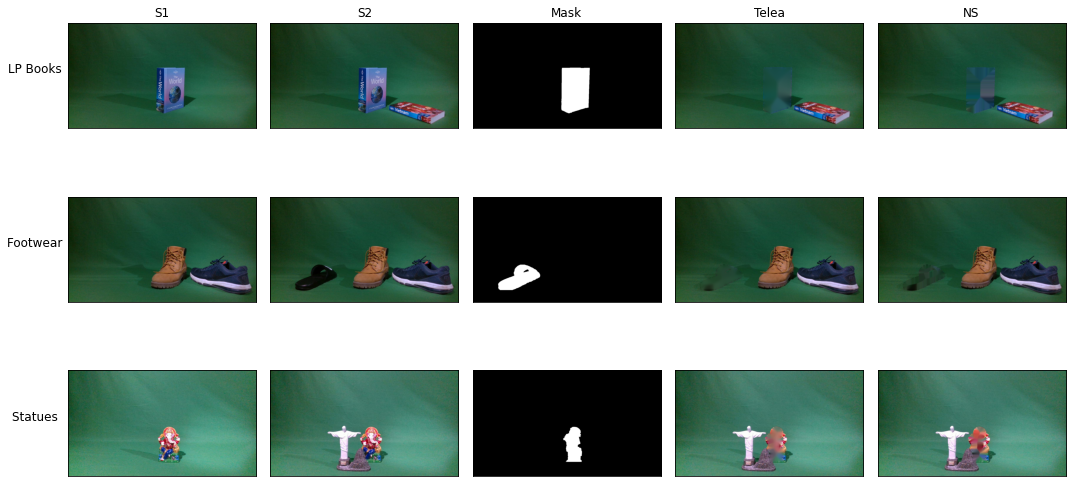

In [11]:
fig, axes = plt.subplots(nrows=len(images), ncols=len(images[0]), figsize=(15, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

for row, image in zip(axes, images):
    for ax, col in zip(row, image):
        ax.imshow(cv2.cvtColor(col, cv2.COLOR_BGR2RGB)) #since mathplotlib uses rgb images and cv2 uses bgr
    
# remove the x and y ticks
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

In [12]:
for i,imgs in enumerate(images):
    print(rows[i])
    for metric in range(1,4):
        print("Telea ", end = '')
        errorValueTelea = CompareResult(imgs[3], imgs[0], metric)
        print("NS ", end = '')
        errorValueNS = CompareResult(imgs[4], imgs[0], metric)
        print()
    print("-------------------------------")

LP Books               
Telea PSNR:  21.52655536061581 dB
NS PSNR:  21.781325594042883 dB

Telea SSIM:  0.8290927736808961
NS SSIM:  0.8296888426374354

Telea MSE:  457.53552987557873
NS MSE:  431.46721498842595

-------------------------------
Footwear               
Telea PSNR:  35.365174057009824 dB
NS PSNR:  33.68827969648998 dB

Telea SSIM:  0.8931438837250396
NS SSIM:  0.8907992225897855

Telea MSE:  18.904402488425927
NS MSE:  27.81329173900463

-------------------------------
Statues               
Telea PSNR:  20.37970589681429 dB
NS PSNR:  20.306284777042446 dB

Telea SSIM:  0.5941966442017844
NS SSIM:  0.5942218952814295

Telea MSE:  595.812720630787
NS MSE:  605.9710593894675

-------------------------------


## Task B - Complex Backgrounds
### Part 1

In [13]:
inpRadius = 30

cols = ["S1","S2","Mask","Telea","NS"]
rows = ["botlesb_nw_no                         ", "booksc_w_oc                         ", "booksc_nw_oc                         ", "cupsa_w_no                         ", "cupsa_w_oc                         ", "electronicsa_nw_no                         ", "foodb_nw_no                         "]

images = []

botlesb_nw_no = []
botlesb_nw_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/bottlesB_nw_no/1_colour.jpeg", 1))
botlesb_nw_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/bottlesB_nw_no/2_colour.jpeg", 1))
mask = cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/bottlesb_nw_no/2_colour.png", 1)
botlesb_nw_no.append(RemoveRedMask(mask))
images.append(botlesb_nw_no)

booksc_w_oc = []
booksc_w_oc.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/booksC_w_oc/2_colour.jpeg", 1))
booksc_w_oc.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/booksC_w_oc/1_colour.jpeg", 1))
booksc_w_oc.append(RemoveRedMask(cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/booksc_w_oc/1_colour.png", 1)))
images.append(booksc_w_oc)

booksc_nw_oc = []
booksc_nw_oc.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/booksC_nw_oc/2_colour.jpeg", 1))
booksc_nw_oc.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/booksC_nw_oc/1_colour.jpeg", 1))
booksc_nw_oc.append(RemoveRedMask(cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/booksc_nw_oc/1_colour.png", 1)))
images.append(booksc_nw_oc)

cupsa_w_no = []
cupsa_w_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/cupsA_w_no/3_colour.jpeg", 1))
cupsa_w_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/cupsA_w_no/1_colour.jpeg", 1))
cupsa_w_no.append(RemoveRedMask(cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/cupsa_w_no/1_colour.png", 1)))
images.append(cupsa_w_no)

cupsa_w_oc = []
cupsa_w_oc.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/cupsA_w_oc/1_colour.jpeg", 1))
cupsa_w_oc.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/cupsA_w_oc/2_colour.jpeg", 1))
cupsa_w_oc.append(RemoveRedMask(cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/cupsa_w_oc/2_colour.png", 1)))
images.append(cupsa_w_oc)
                             
electronicsa_nw_no = []
electronicsa_nw_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/electronicsA_nw_no/3_colour.jpeg", 1))
electronicsa_nw_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/electronicsA_nw_no/2_colour.jpeg", 1))
electronicsa_nw_no.append(RemoveRedMask(cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/electronicsa_nw_no/2_colour.png", 1)))
images.append(electronicsa_nw_no)

foodb_nw_no = []
foodb_nw_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/foodB_nw_no/1_colour.jpeg", 1))
foodb_nw_no.append(cv2.imread("COTSDataset-master/Part 3 - Complex Background/foodB_nw_no/2_colour.jpeg", 1))
foodb_nw_no.append(RemoveRedMask(cv2.imread("COTSDataset-master/Part 3 - Complex Background/masks/foodb_nw_no/2_colour.png", 1)))
images.append(foodb_nw_no)

for i,imgs in enumerate(images):
    mask = convImgToBinary(imgs[2])
    imgs.append(inpaintTelea(imgs[1], mask, inpRadius))
    imgs.append(inpaintNS(imgs[1], mask, inpRadius))
    saveImage(imgs[0], ("Task B/" + rows[i].strip() + "-S1.jpg"))
    saveImage(imgs[1], ("Task B/" + rows[i].strip() + "-S2.jpg"))
    saveImage(imgs[2], ("Task B/" + rows[i].strip() + "-Mask.jpg"))
    saveImage(imgs[3], ("Task B/" + rows[i].strip() + "-Telea.jpg"))
    saveImage(imgs[4], ("Task B/" + rows[i].strip() + "-NS.jpg"))

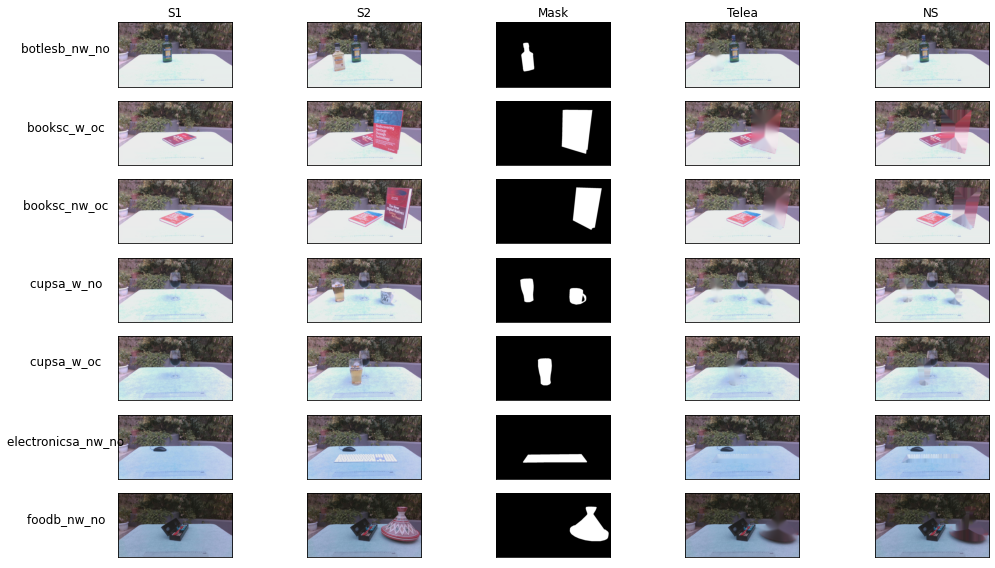

In [14]:
fig, axes = plt.subplots(nrows=len(images), ncols=len(images[0]), figsize=(15, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

for row, image in zip(axes, images):
    for ax, col in zip(row, image):
        ax.imshow(cv2.cvtColor(col, cv2.COLOR_BGR2RGB)) #since mathplotlib uses rgb images and cv2 uses bgr
    
# remove the x and y ticks
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

In [15]:
for i,imgs in enumerate(images):
    print(rows[i])
    for metric in range(1,4):
        print("Telea ", end = '')
        errorValueTelea = CompareResult(imgs[3], imgs[0], metric)
        print("NS ", end = '')
        errorValueNS = CompareResult(imgs[4], imgs[0], metric)
        print()
    print("-------------------------------")

botlesb_nw_no                         
Telea PSNR:  32.24546557670554 dB
NS PSNR:  31.444698510512488 dB

Telea SSIM:  0.946636216622664
NS SSIM:  0.9456169702232388

Telea MSE:  38.77339265046297
NS MSE:  46.62410517939815

-------------------------------
booksc_w_oc                         
Telea PSNR:  24.30435490554617 dB
NS PSNR:  23.24085919493521 dB

Telea SSIM:  0.8363551579838285
NS SSIM:  0.8342070482906498

Telea MSE:  241.34864800347222
NS MSE:  308.3148488136574

-------------------------------
booksc_nw_oc                         
Telea PSNR:  26.901545735935063 dB
NS PSNR:  24.270793368540218 dB

Telea SSIM:  0.9254786099145719
NS SSIM:  0.9222881968942961

Telea MSE:  132.7167650462963
NS MSE:  243.22097439236111

-------------------------------
cupsa_w_no                         
Telea PSNR:  26.07833168320284 dB
NS PSNR:  25.76416774133167 dB

Telea SSIM:  0.8241896477641433
NS SSIM:  0.8232077189019522

Telea MSE:  160.41581886574073
NS MSE:  172.4501540798611

-----

### Part 2

In [18]:
image1 = cv2.imread("COTSDataset-master/Part 1 - Single Objects/scene_green/empty_controlled_colour.jpeg",1)
image2 = cv2.imread("COTSDataset-master/Part 1 - Single Objects/objects/shooter_glass1_colour.jpeg",1)

getDiffBetweenImgs(image1, image2)

Image similarity 0.9071537926381282


In [16]:
image1 = cv2.imread("COTSDataset-master/Part 3 - Complex Background/cupsA_nw_no/1_colour.jpeg",1)
image2 = cv2.imread("COTSDataset-master/Part 3 - Complex Background/cupsA_nw_no/2_colour.jpeg",1)

getDiffBetweenImgs(image1, image2)

Image similarity 0.9219342677503853


In [19]:
image1 = cv2.imread("COTSDataset-master/Part 3 - Complex Background/booksA_w_no/1_colour.jpeg",1)
image2 = cv2.imread("COTSDataset-master/Part 3 - Complex Background/booksA_w_no/2_colour.jpeg",1)

getDiffBetweenImgs(image1, image2)

Image similarity 0.8484828444580871
